<font color="#483D8B">
<h1  align="center"> Recognizing Emotion in Speech With Neural Networks </h1>
<div align="center">
<font size=3><b>
<br>INET 4061 Project Third Draft
<br>Tony Zeng
<br>December 1, 2019
<br></font></b></div>

# Overview
Human emotions can be found through our daily speech. If we are angry, someone might raise their voice. If someone is sad, you might hear abrupt speech patterns. This project will look into audio files from both a male and female to predict such emotions such as happy, sad, angry, etc. 
<br/>
<br/>

There are some major obstacles with speech emotion recognition:
* Emotions are subjective, people would interpret it differently. It is hard to define the notion of emotions.
* Annotating an audio recording is challenging. Should we label a single word, sentence or a whole conversation? How many emotions should we define to recognize?
* Collecting data is complex. There are lots of audio data can be achieved from films or news. However, both of them are biased since news reporting has to be neutral and actors’ emotions are imitated. It is hard to look for neutral audio recording without any bias.
* Labeling data require high human and time cost. Unlike drawing a bounding box on an image, it requires trained personnel to listen to the whole audio recording, analysis it and give an annotation. The annotation result has to be evaluated by multiple individuals due to its subjectivity.

Definitions:
* Mel Frequency Cepstral Coefficient (MFCC): The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. 

References:
* https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer
* https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb

# Data

The data we will be using for this is the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). The database contains 24 professional actors (12 female, 12 male) vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
<br/>

#### File naming convention
Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Emotions
In this database, we will be looking at a couple of different emotions, this includes:
* Neutral (Not in song version of data)
* Calm
* Happy
* Sad
* Angry
* Fearful
* Disgust (Not in song version of data)
* Surprised (Not in song version of data)

#### Steps to Reproduct the data for this notebook
We will be using the Audio-only files. In specific, we will be using the Song files which contains 1012 files: 44 trials per actor X 23 actors = 1012.
1. To get the data, go to : https://zenodo.org/record/1188976#.XcuWi1dKiUl
2. Go down and look for the file named: Audio_Song_Actors_01-24.zip. The size of the file is 225.5 MB.
3. 

In [1]:
#Imports
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Exploratory Data Analysis

In [2]:
#Take a look at one of the audio files
data, sampling_rate = librosa.load(r'C:\Users\tzeng\Documents\INET 4061\INET-4061-Project\ravdess\Actor_01\03-02-01-01-01-01-01.wav')

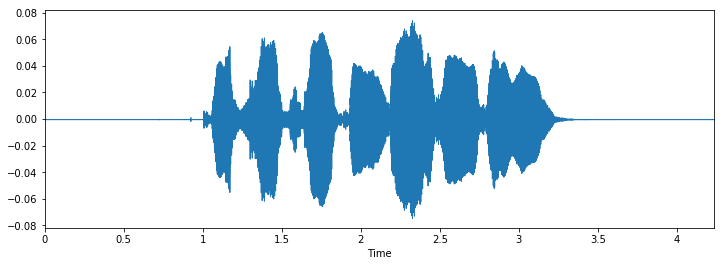

In [3]:
%matplotlib inline
import os
import pandas as pd
import glob

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

This is the waveform graph for one of the audio files in our dataset. The audio file we used was labeled as 03-02-01-01-01-01-01.wav. This means that this file is audio-only, a song, neutral emotion, normal emotional intensity, statement: "Kids are talking by the door", 1st reptition, actor 1. This is what neutral emotion sound file should look like when looking at its waveform.

C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


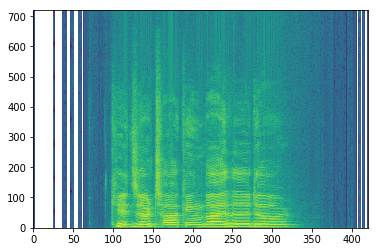

In [4]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('ravdess/Actor_01/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [5]:
import time

path = 'ravdess/'
feeling_list = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        if file[6:-16] == '02' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_calm')
        elif file[6:-16] == '02' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_calm')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_happy')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_happy')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_sad')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_sad')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_angry')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_angry')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_fearful')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_fearful')
        elif file[:1] == 'a':
            feeling_list.append('male_angry')
        elif file[:1] == 'f':
            feeling_list.append('male_fearful')
        elif file[:1] == 'h':
            feeling_list.append('male_happy')
        elif file[:2] == 'sa':
            feeling_list.append('male_sad')

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.35581374168395996 seconds ---


In [61]:
#Verify that mfccs were populated in the list
print(feeling_list[1:10])

['male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_happy', 'male_happy']


In [7]:
labels = pd.DataFrame(feeling_list)

In [8]:
labels.head()

,0
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm


In [9]:
df = pd.DataFrame(columns=['feature'])
bookmark=0

path = 'ravdess/'

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            if file[6:-16]!='01' and file[6:-16]!='07' and file[6:-16]!='08' and file[:2]!='su' and file[:1]!='n' and file[:1]!='d':
                X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                    sr=sample_rate, 
                                                    n_mfcc=13), axis=0)
                feature = mfccs
                df.loc[bookmark] = [feature]
                bookmark=bookmark+1
        except ValueError:
            continue
            
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 174.35243439674377 seconds ---


In [10]:
df[:5]

,feature
0,"[-61.542942, -61.670296, -61.663513, -61.67559..."
1,"[-60.61303, -60.61303, -60.61303, -60.61303, -..."
2,"[-61.929478, -61.929478, -61.929478, -61.92947..."
3,"[-59.151585, -59.151585, -59.151585, -59.15158..."
4,"[-65.0231, -65.0231, -65.0231, -65.0231, -65.0..."


In [11]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [12]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-61.542942,-61.670296,-61.663513,-61.675594,-59.627468,-58.578270,-60.384651,-60.370808,-59.209068,-59.793674,...,-28.921122,-32.029648,-28.536741,-27.502647,-26.418861,-27.831207,-28.752033,-28.786448,-21.615858,-17.308699
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-26.426582,-24.405365,-23.668781,-26.999542,-31.112379,-29.247231,-25.843218,-25.077202,-26.445538,-23.854166
2,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394730,-61.859245,-61.559097,-61.015484,-59.214943,...,-26.654114,-29.230816,-31.035513,-30.716604,-32.136162,-31.681684,-30.169340,-28.785442,-21.420412,-17.509743
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-31.761593,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-26.300121,-25.822012,-26.811405,-28.635292,-30.002089,-32.346748,-34.095303,-34.079765,-23.301119,-17.947981


In [13]:
newdf = pd.concat([df3, labels], axis=1)

In [62]:
newdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542942,-61.670296,-61.663513,-61.675594,-59.627468,-58.578270,-60.384651,-60.370808,-59.209068,-59.793674,...,-32.029648,-28.536741,-27.502647,-26.418861,-27.831207,-28.752033,-28.786448,-21.615858,-17.308699,male_calm
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-24.405365,-23.668781,-26.999542,-31.112379,-29.247231,-25.843218,-25.077202,-26.445538,-23.854166,male_calm
2,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394730,-61.859245,-61.559097,-61.015484,-59.214943,...,-29.230816,-31.035513,-30.716604,-32.136162,-31.681684,-30.169340,-28.785442,-21.420412,-17.509743,male_calm
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303,male_calm
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822012,-26.811405,-28.635292,-30.002089,-32.346748,-34.095303,-34.079765,-23.301119,-17.947981,male_calm


In [14]:
rnewdf = newdf.rename(index=str, columns={"0":"label"})
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542942,-61.670296,-61.663513,-61.675594,-59.627468,-58.578270,-60.384651,-60.370808,-59.209068,-59.793674,...,-32.029648,-28.536741,-27.502647,-26.418861,-27.831207,-28.752033,-28.786448,-21.615858,-17.308699,male_calm
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-24.405365,-23.668781,-26.999542,-31.112379,-29.247231,-25.843218,-25.077202,-26.445538,-23.854166,male_calm
2,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394730,-61.859245,-61.559097,-61.015484,-59.214943,...,-29.230816,-31.035513,-30.716604,-32.136162,-31.681684,-30.169340,-28.785442,-21.420412,-17.509743,male_calm
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303,male_calm
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822012,-26.811405,-28.635292,-30.002089,-32.346748,-34.095303,-34.079765,-23.301119,-17.947981,male_calm


The shuffle function shuffles the dataframe in a consistent manner so that we are not going in order or emotions and actors/actresses. Without the shuffle, we would be going through numerical order of each actor's sound files which would not be a very representative test. So instead, we will shuffle the data to be more random.

In [15]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
219,-58.031319,-58.877419,-59.157879,-60.151321,-62.254433,-61.266518,-61.767124,-64.246819,-64.945503,-65.388542,...,-49.715633,-50.159794,-51.296577,-50.567207,-50.757259,-47.647545,-45.339138,-44.481480,-43.565548,female_sad
316,-49.169247,-49.617573,-50.263454,-50.012081,-50.329685,-50.229256,-49.457726,-48.900043,-48.370094,-46.886745,...,-40.836990,-40.059372,-39.967972,-42.939087,-43.754326,-44.279148,-43.565708,-32.201927,-24.222775,female_fearful
353,-52.855106,-53.716030,-54.941463,-57.121029,-56.383236,-55.046635,-55.106632,-55.330116,-56.333759,-54.900307,...,-29.363056,-29.371086,-29.149221,-30.023275,-30.475883,-31.300150,-31.371708,-28.309053,-23.989973,male_fearful
247,-68.997314,-68.997314,-68.997314,-68.997314,-68.997314,-68.997314,-68.997314,-68.997314,-68.778633,-67.852333,...,-33.209770,-33.959824,-33.268486,-33.870827,-35.111130,-32.855980,-31.973976,-23.746824,-18.142818,male_calm
576,-50.116844,-50.412823,-51.566494,-52.831680,-52.666336,-52.627769,-52.863098,-51.289463,-49.945091,-49.799412,...,-31.131624,-30.176149,-30.538576,-31.571573,-30.484798,-29.516214,-30.900331,-24.733377,-20.154203,male_sad
721,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,-62.121197,...,-48.446335,-47.191582,-45.627640,-46.632465,-45.855843,-47.710793,-47.872288,-28.108046,-19.558071,female_calm
748,-39.537090,-39.431149,-40.677284,-40.809727,-39.240330,-39.752342,-40.665897,-41.897682,-41.435825,-40.339706,...,-34.034859,-34.266594,-32.948532,-31.580627,-30.157278,-29.652496,-31.157112,-11.088129,-2.605711,female_angry
702,-52.456600,-52.451847,-53.038826,-53.425285,-53.594322,-53.462978,-54.931046,-55.912518,-56.181553,-59.222721,...,-33.355156,-33.820831,-33.811550,-33.802132,-30.590660,-29.667400,-29.439796,-27.047514,-21.376251,male_sad
447,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,-57.894417,...,-44.252609,-42.623325,-40.065716,-37.475906,-36.227783,-37.551445,-39.328560,-26.474823,-19.189827,female_calm
357,-51.582542,-50.957535,-51.229370,-51.757290,-52.012375,-51.750229,-50.193256,-46.999577,-45.872707,-45.046593,...,-27.426849,-28.060581,-29.361835,-26.532412,-24.975147,-21.543062,-19.522160,-20.446510,-23.996178,male_fearful


In [ ]:
rnewdf.isna().sum()

In [16]:
rnewdf = rnewdf.fillna(0)

### Divide the data into test and train

The way we divide the test and train data is by 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
#newdf1 = np.random.rand(len(rnewdf)) < 0.8
#train = rnewdf[newdf1]
#test = rnewdf[~newdf1]

In [18]:
#train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
705,-52.212990,-51.814053,-51.424747,-52.292538,-52.863705,-53.732857,-53.039242,-52.298298,-51.704758,-52.409279,...,-23.806206,-23.593676,-22.673929,-24.671892,-24.433474,-24.783009,-24.481459,-20.225027,-15.433872,male_angry
401,-53.194805,-52.541592,-52.966316,-53.961716,-55.077660,-52.347439,-52.414654,-52.837177,-52.158108,-55.248737,...,-28.136850,-28.602924,-29.713200,-29.169521,-29.809475,-29.803305,-31.081747,-21.695292,-15.482435,male_calm
781,-53.980587,-53.863075,-55.297256,-55.569004,-53.815224,-53.594612,-51.804634,-50.267700,-50.514957,-49.740784,...,-27.312580,-26.760139,-26.864443,-28.179514,-28.543627,-28.108097,-28.468113,-18.224888,-13.195655,male_sad
484,-64.317513,-63.766804,-60.722061,-58.670479,-60.333698,-63.127808,-62.958984,-63.293922,-62.391045,-62.594948,...,-35.277081,-34.201962,-32.926655,-33.722824,-33.561790,-33.741512,-34.679417,-32.458519,-30.145760,male_calm
816,-54.403652,-52.811092,-53.239090,-54.285748,-53.518276,-54.753990,-54.446384,-53.813362,-53.305908,-52.992855,...,-42.065708,-41.953621,-42.201431,-42.743813,-42.407314,-42.150906,-41.963741,-23.568813,-14.848024,female_sad
27,-48.054939,-48.312485,-49.320747,-49.431705,-49.417404,-48.531834,-48.558472,-49.101768,-49.133198,-48.306881,...,-20.579590,-19.981112,-20.940615,-21.621319,-23.302919,-24.998501,-22.833809,-14.498587,-10.712704,male_angry
896,-61.116108,-61.182049,-61.153950,-61.116108,-61.127327,-61.484276,-61.930790,-62.137962,-61.608505,-61.129616,...,-47.050686,-45.928921,-48.077248,-48.512451,-47.164555,-45.601559,-46.416874,-33.938515,-25.520191,female_sad
327,-51.614197,-50.370422,-50.572407,-53.417351,-51.839863,-50.804974,-52.358036,-54.144272,-53.733665,-51.152466,...,-37.709610,-37.881386,-38.687050,-38.629570,-37.864555,-36.887749,-35.916470,-32.598213,-29.486681,male_calm
755,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,-62.548649,...,-52.792698,-52.842720,-54.350883,-54.291458,-53.457054,-52.820797,-52.375038,-49.474007,-44.360821,female_fearful
270,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,-54.161194,...,-20.744997,-21.558104,-22.241932,-19.537416,-20.882368,-22.576969,-22.316051,-21.369459,-20.788218,male_angry


In [19]:
#trainfeatures = train.iloc[:, :-1]
#trainlabel = train.iloc[:, -1:]
#testfeatures = test.iloc[:, :-1]
#testlabel = test.iloc[:, -1:]

In [20]:
from tensorflow.python.keras import utils
from sklearn.preprocessing import LabelEncoder

#X_train = np.array(trainfeatures)
#y_train = np.array(trainlabel)
#X_test = np.array(testfeatures)
#y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = utils.to_categorical(lb.fit_transform(y_train))
y_test = utils.to_categorical(lb.fit_transform(y_test))

C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X_train.shape

(747, 216)

# Model

### Building our neural network

In [23]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [24]:
x_traincnn.shape, x_testcnn.shape

((747, 216, 1), (173, 216, 1))

In [25]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [28]:

cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Train on 747 samples, validate on 173 samples
Epoch 1/100
747/747 [==============================] - 18s 23ms/sample - loss: 2.2852 - accuracy: 0.1473 - val_loss: 2.1534 - val_accuracy: 0.1156
Epoch 2/100
747/747 [==============================] - 12s 17ms/sample - loss: 2.1245 - accuracy: 0.1954 - val_loss: 2.1555 - val_accuracy: 0.0925
Epoch 3/100
747/747 [==============================] - 7s 9ms/sample - loss: 2.0171 - accuracy: 0.2450 - val_loss: 1.9671 - val_accuracy: 0.2254
Epoch 4/100
747/747 [==============================] - 6s 8ms/sample - loss: 1.9249 - accuracy: 0.2851 - val_loss: 2.0121 - val_accuracy: 0.2486
Epoch 5/100
747/747 [==============================] - 7s 9ms/sample - loss: 1.8591 - accuracy: 0.2517 - val_loss: 1.8872 - val_accuracy: 0.3121
Epoch 6/100
747/747 [==============================] - 9s 13ms/sample - loss: 1.7802 - accuracy: 0.3039 - val_loss: 1.7946 - val_accuracy: 0.3121
Epoch 7/100
747/747 [==============================] - 9s 12ms/sample - loss: 1

Epoch 57/100
747/747 [==============================] - 6s 9ms/sample - loss: 0.8812 - accuracy: 0.6519 - val_loss: 1.1219 - val_accuracy: 0.5087
Epoch 58/100
747/747 [==============================] - 6s 8ms/sample - loss: 0.8501 - accuracy: 0.6774 - val_loss: 1.1869 - val_accuracy: 0.5376
Epoch 59/100
747/747 [==============================] - 6s 8ms/sample - loss: 0.8649 - accuracy: 0.6640 - val_loss: 1.1321 - val_accuracy: 0.5145
Epoch 60/100
747/747 [==============================] - 6s 8ms/sample - loss: 0.8414 - accuracy: 0.6693 - val_loss: 1.1206 - val_accuracy: 0.4855
Epoch 61/100
747/747 [==============================] - 6s 8ms/sample - loss: 0.8455 - accuracy: 0.6627 - val_loss: 1.1487 - val_accuracy: 0.5318
Epoch 62/100
747/747 [==============================] - 7s 9ms/sample - loss: 0.8263 - accuracy: 0.6881 - val_loss: 1.1784 - val_accuracy: 0.5434
Epoch 63/100
747/747 [==============================] - 7s 9ms/sample - loss: 0.8156 - accuracy: 0.6921 - val_loss: 1.2865 -

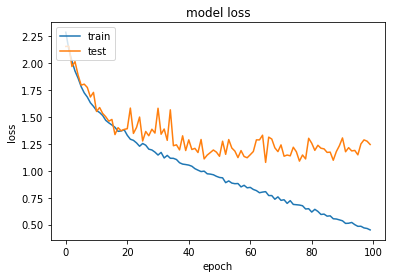

In [29]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

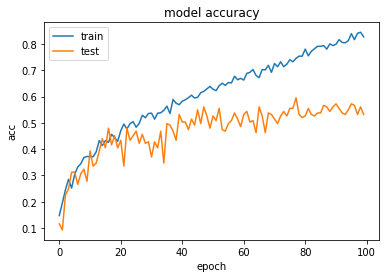

In [31]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save the Model

In [41]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\tzeng\Documents\INET 4061\INET-4061-Project\saved_models\Emotion_Voice_Detection_Model.h5 


### Reload the Saved Model

In [45]:
loaded_model = keras.models.load_model(r'C:\Users\tzeng\Documents\INET 4061\INET-4061-Project\saved_models\Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

### Predicting Emotions on Test Data

In [46]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

173/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [47]:
preds

array([[9.9985468e-01, 6.9348641e-07, 1.8649641e-06, ..., 1.6078238e-06,
        6.5510079e-08, 4.9438384e-08],
       [5.2732735e-06, 1.6152671e-11, 4.2058709e-03, ..., 7.4544835e-01,
        1.3784358e-03, 2.4354702e-01],
       [2.5872388e-01, 1.8568235e-09, 6.7451811e-01, ..., 1.0794254e-03,
        3.3626084e-06, 5.3795343e-08],
       ...,
       [4.7208168e-06, 1.1571336e-09, 3.1936108e-07, ..., 4.0158916e-01,
        5.2507281e-01, 3.3043583e-05],
       [9.6566208e-02, 9.1069692e-04, 2.3316705e-01, ..., 5.9819754e-06,
        5.7539396e-06, 1.2142259e-05],
       [1.2644954e-05, 3.7429602e-06, 5.3948364e-03, ..., 3.6852963e-02,
        5.2571803e-04, 6.9136536e-01]], dtype=float32)

In [48]:
preds1=preds.argmax(axis=1)

In [49]:
preds1

array([0, 7, 2, 8, 1, 2, 7, 3, 5, 4, 4, 0, 4, 6, 1, 5, 4, 3, 8, 8, 4, 2,
       5, 2, 8, 7, 2, 2, 8, 2, 0, 3, 5, 1, 2, 1, 6, 9, 2, 3, 3, 4, 2, 3,
       4, 4, 8, 0, 2, 2, 8, 4, 2, 2, 4, 2, 3, 7, 2, 0, 0, 4, 0, 6, 7, 9,
       7, 3, 1, 0, 8, 6, 2, 2, 6, 1, 1, 5, 2, 5, 6, 6, 1, 5, 8, 0, 0, 5,
       7, 7, 7, 3, 7, 8, 9, 9, 4, 2, 6, 7, 2, 0, 7, 4, 2, 8, 6, 7, 4, 9,
       3, 0, 8, 5, 8, 2, 3, 1, 1, 9, 0, 7, 3, 7, 1, 7, 6, 2, 5, 4, 5, 0,
       9, 0, 0, 7, 8, 7, 9, 2, 0, 4, 4, 1, 0, 8, 7, 8, 7, 1, 5, 6, 7, 7,
       8, 4, 2, 4, 8, 8, 7, 0, 5, 3, 5, 3, 6, 5, 2, 8, 8, 3, 9],
      dtype=int64)

In [50]:
abc = preds1.astype(int).flatten()

In [51]:
predictions = (lb.inverse_transform((abc)))

In [52]:
preddf = pd.DataFrame({'Predicted Values': predictions})
preddf[:10]

,predictedvalues
0,female_angry
1,male_fearful
2,female_fearful
3,male_happy
4,female_calm
5,female_fearful
6,male_fearful
7,female_happy
8,male_angry
9,female_sad


In [53]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [54]:
actualdf = pd.DataFrame({'Actual Values': actualvalues})
actualdf[:10]

,actualvalues
0,female_angry
1,male_fearful
2,female_fearful
3,male_sad
4,female_calm
5,female_sad
6,male_angry
7,female_fearful
8,male_fearful
9,female_happy


In [55]:
finaldf = actualdf.join(preddf)

In [57]:
finaldf[10:20]

,actualvalues,predictedvalues
10,female_sad,female_sad
11,female_angry,female_angry
12,female_sad,female_sad
13,male_calm,male_calm
14,female_calm,female_calm
15,male_angry,male_angry
16,female_sad,female_sad
17,female_fearful,female_happy
18,male_fearful,male_happy
19,male_happy,male_happy


In [58]:
finaldf.groupby('Actual Values').count()

,predictedvalues
actualvalues,
female_angry,13
female_calm,22
female_fearful,20
female_happy,18
female_sad,18
male_angry,21
male_calm,11
male_fearful,21
male_happy,14


In [59]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,19
female_calm,13
female_fearful,27
female_happy,15
female_sad,19
male_angry,15
male_calm,12
male_fearful,23
male_happy,21


### Checking Accuracy of the Loaded Model

In [60]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

173/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Conclusion